# Let's start with a few papers representation

1. "Multivariate Time Series Analysis with R and Financial Applications" by Ruey S. Tsay (2014)

This book provides comprehensive coverage of multivariate time series analysis, including VARMAX models, with applications in financial markets. It offers practical examples and R code implementations

2. "Dynamic Stock Market Analysis with VAR and VARMAX Models" by Mehmet Balcilar, Rangan Gupta, Chinzara Zethu (2013)

This paper discusses the use of VAR and VARMAX models in the context of stock market analysis. It provides empirical evidence on the effectiveness of these models in capturing the dynamic relationships between different stock indices and macroeconomic variables.

3. "Volatility Transmission Between Stock Returns and Foreign Exchange Rates: A Bivariate GARCH Analysis" by Cheol S. Eun and Sangdal Shim (1989)

Although this paper primarily focuses on GARCH models, it provides insights into the transmission of volatility between stock markets and exchange rates, which is relevant for understanding the broader context of financial time series analysis and the importance of multivariate modeling techniques like VARMAX

4. "The Impact of Economic News on Financial Markets: Evidence from Professional Traders" by John M. Campbell, Stefano Giglio, Christopher Polk, and Robert Turley (2018)

This study investigates the impact of economic news on financial markets using multivariate time series models. It highlights the importance of incorporating exogenous variables into the analysis, a key feature of VARMAX models, to understand the influence of external factors on market movements.

And one more paper 
https://www.researchgate.net/publication/352197415_REVIEW_OF_STOCK_PREDICTION_USING_MACHINE_LEARNING_TECHNIQUES 


# Let's import nessesary libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from scipy.stats import zscore
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller 
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



#  Load and Prepare Data

In [21]:
# Fetch stock data
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
data = yf.download(tickers, start='1996-01-01', end='2024-04-01')['Close']

[*********************100%%**********************]  4 of 4 completed


In [22]:
df = pd.DataFrame(data)
df = df.dropna()
df

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2004-08-19,0.548393,1.931500,2.511011,27.120001
2004-08-20,0.550000,1.975500,2.710460,27.200001
2004-08-23,0.555000,1.972500,2.737738,27.240000
2004-08-24,0.570536,1.952500,2.624374,27.240000
2004-08-25,0.590179,2.015000,2.652653,27.549999
...,...,...,...,...
2024-03-22,172.279999,178.869995,150.770004,428.739990
2024-03-25,170.850006,179.710007,150.070007,422.859985
2024-03-26,169.710007,178.300003,150.669998,421.649994


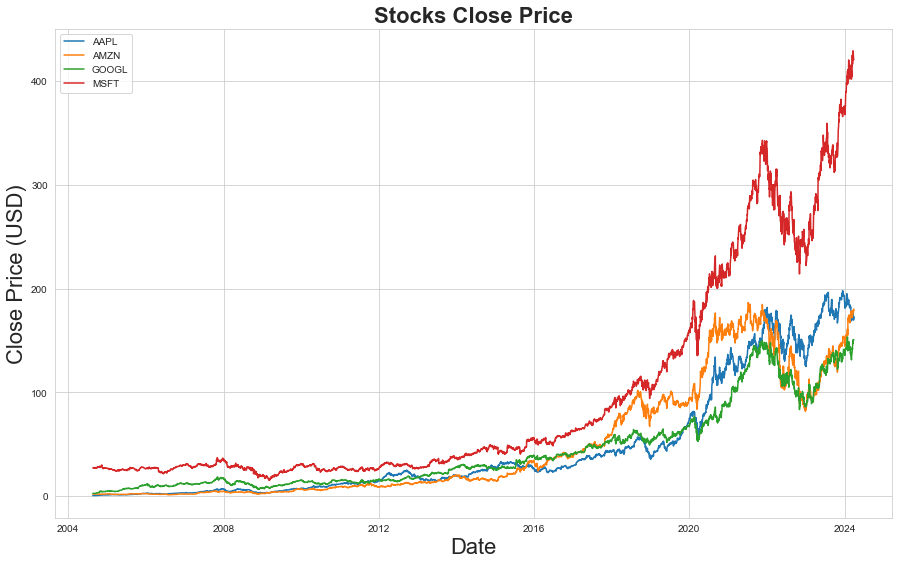

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize = (15, 9))
plt.plot(df)
plt.title("Stocks Close Price", fontsize=22, fontweight='bold')
plt.xlabel('Date', fontsize=22)
plt.ylabel('Close Price (USD)', fontsize=22)
plt.legend(df.columns)

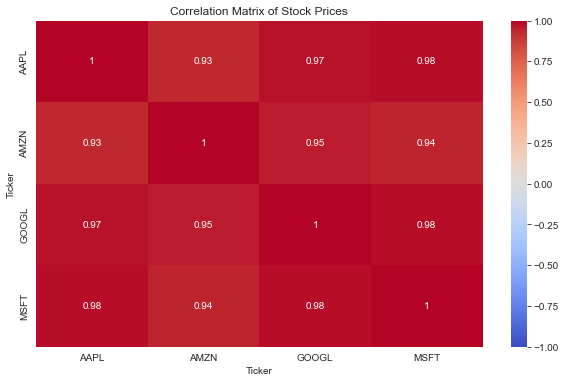

In [24]:
correlation_matrix_prices = data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_prices, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stock Prices')
plt.show()

## Why Use Returns for VAR Models?
1. Stationarity:  
Returns are usually more stationary than raw prices. Stationarity is a critical assumption for VARMAX models, and non-stationary data can lead to misleading results.
Prices often exhibit trends and other non-stationary behaviors, whereas returns (particularly log returns) tend to be stationary.

2. Comparability: Returns provide a normalized measure of performance, making it easier to compare different stocks regardless of their price levels.

3. Financial Theory: Many financial models and theories (such as the Capital Asset Pricing Model, or CAPM) are based on returns rather than prices.

### Using the last observation of the month instead of the mean is a common practice when analyzing financial time series data for several reasons:

1. Consistency with Financial Reporting: Many financial reports and performance metrics are based on end-of-period (EoP) values. Investors and analysts often look at the closing prices at the end of the month to assess performance.

2. Reflects Market Closing Prices: The closing price is the final price at which a stock is traded during the regular trading hours for that month. It is considered a good representation of the stock's value at the end of the period.

3. Volatility Consideration: The mean of daily prices within a month can smooth out volatility and may not accurately represent the actual performance or risk observed by investors who focus on closing prices.

4. Alignment with Return Calculations: When calculating monthly returns, we typically look at the price change from the closing price of one month to the closing price of the next month. This approach directly aligns with how returns are typically computed and analyzed in finance.
However, using the mean can be beneficial in certain contexts, such as when you want to reduce the impact of outliers or when you are dealing with very volatile data. Both methods have their own merits, but for the reasons stated above, the last observation method is often preferred in financial analysis.

In [25]:
monthly_data_price_last = data.resample('M').last()
monthly_data_price_mean = data.resample('M').mean()

# Calculate Monthly Returns for both methods
monthly_returns_last = monthly_data_price_last.pct_change().dropna()
monthly_returns_mean = monthly_data_price_mean.pct_change().dropna()

In [26]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    adf_result = {
        'ADF Test Statistic': result[0],
        'p-value': result[1],
        '#Lags Used': result[2],
        'Number of Observations Used': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
        'Stationary': result[1] <= 0.05
    }
    return adf_result

print('ADF test for last')
adf_results = pd.DataFrame()
for ticker in monthly_returns_last.columns:
    adf_result = adf_test(monthly_returns_last[ticker])
    adf_results[ticker] = pd.Series(adf_result)

print(adf_results, '\n \n')

print('ADF test for mean')
adf_results = pd.DataFrame()
for ticker in monthly_returns_mean.columns:
    adf_result = adf_test(monthly_returns_mean[ticker])
    adf_results[ticker] = pd.Series(adf_result)

print(adf_results)


ADF test for last
                                  AAPL       AMZN      GOOGL       MSFT
ADF Test Statistic          -13.333119 -15.702424 -14.823304 -16.100901
p-value                            0.0        0.0        0.0        0.0
#Lags Used                           0          0          0          0
Number of Observations Used        234        234        234        234
Critical Value (1%)          -3.458608  -3.458608  -3.458608  -3.458608
Critical Value (5%)          -2.873972  -2.873972  -2.873972  -2.873972
Critical Value (10%)         -2.573396  -2.573396  -2.573396  -2.573396
Stationary                        True       True       True       True 
 

ADF test for mean
                                 AAPL       AMZN      GOOGL       MSFT
ADF Test Statistic          -9.774918 -12.364368 -11.093079 -12.044848
p-value                           0.0        0.0        0.0        0.0
#Lags Used                          1          0          1          0
Number of Observations Used 

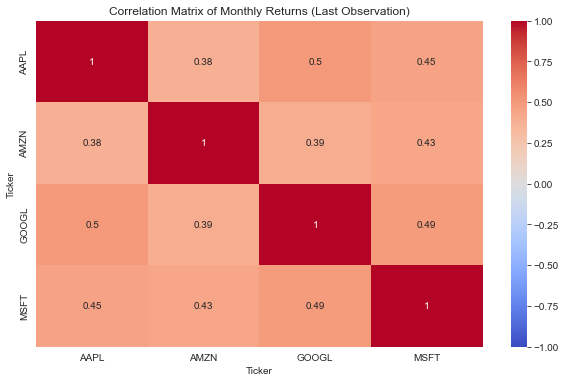

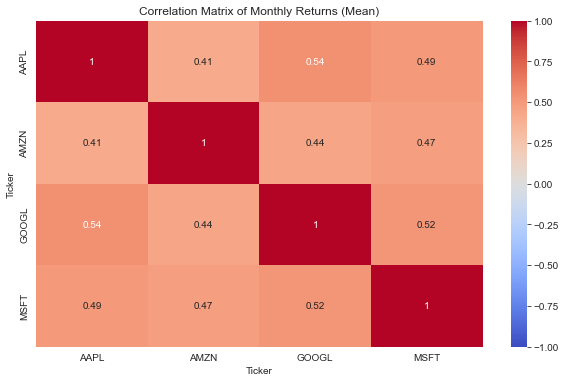

In [27]:
#Plot Correlation Matrix for Monthly Returns (Last Observation)
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_returns_last.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Monthly Returns (Last Observation)')

#Plot Correlation Matrix for Monthly Returns (Mean)
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_returns_mean.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Monthly Returns (Mean)')
plt.show()

In [28]:
monthly_returns = monthly_returns_last

In [29]:
description = monthly_returns.describe()
description

Ticker,AAPL,AMZN,GOOGL,MSFT
count,235.000000,235.000000,235.000000,235.000000
mean,0.028697,0.024838,0.021151,0.013799
std,0.094646,0.104887,0.087835,0.065239
min,-0.329558,-0.304809,-0.184773,-0.165644
25%,-0.032739,-0.044373,-0.034227,-0.031795
50%,0.032704,0.024369,0.018753,0.017116
75%,0.093968,0.082750,0.068198,0.054113
max,0.352258,0.541342,0.470988,0.249491


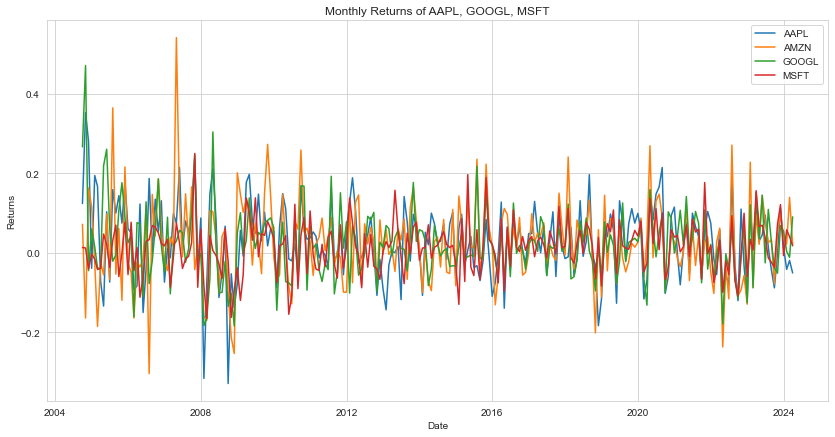

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(monthly_returns)
plt.title('Monthly Returns of AAPL, GOOGL, MSFT')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(monthly_returns.columns)
plt.grid(True)
plt.show()

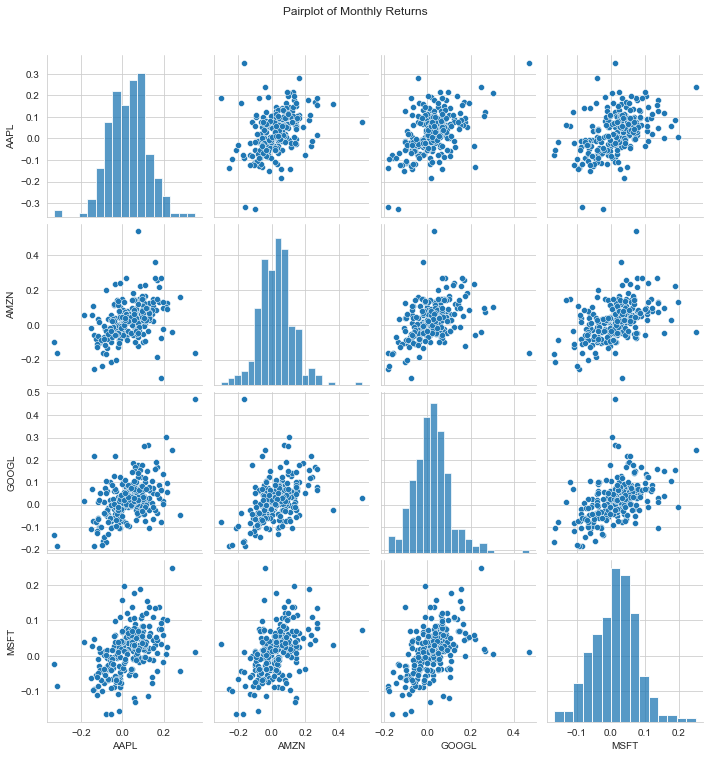

In [31]:
sns.pairplot(monthly_returns)
plt.suptitle('Pairplot of Monthly Returns', y=1.05)
plt.show()

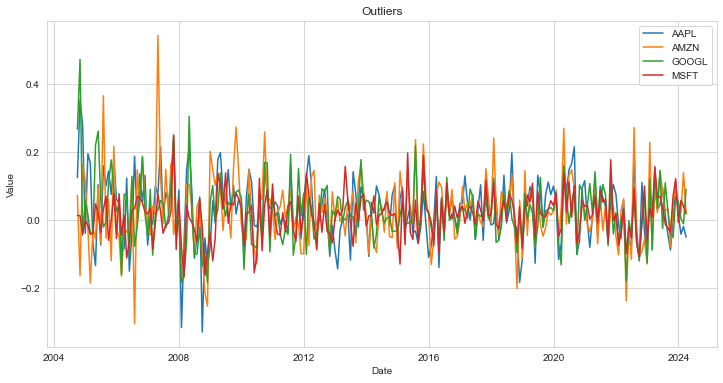

Outliers detected!

Step 3: Handling outliers by replacing with median...
Outliers handled.


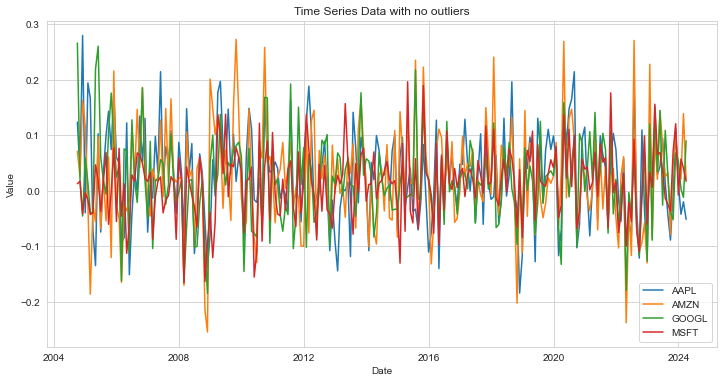

Correlation Matrix without outliers:
Ticker      AAPL      AMZN     GOOGL      MSFT
Ticker                                        
AAPL    1.000000  0.457848  0.409916  0.447345
AMZN    0.457848  1.000000  0.506098  0.484380
GOOGL   0.409916  0.506098  1.000000  0.510165
MSFT    0.447345  0.484380  0.510165  1.000000 

Correlation Matrix with outliers:
Ticker      AAPL      AMZN     GOOGL      MSFT
Ticker                                        
AAPL    1.000000  0.381092  0.497343  0.449652
AMZN    0.381092  1.000000  0.391198  0.433454
GOOGL   0.497343  0.391198  1.000000  0.486753
MSFT    0.449652  0.433454  0.486753  1.000000


In [32]:
# Visual inspection for outliers
plt.figure(figsize=(12, 6))
for column in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[column], label=column)
plt.title('Outliers')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Function to handle outliers by replacing with median
def handle_outliers(data, outliers):
    data_no_outliers = data.copy()
    for column in data.columns:
        data_no_outliers.loc[outliers, column] = data[column].median()
    return data_no_outliers

# Function to detect outliers using Z-score method
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(zscore(data))
    outliers = (z_scores > threshold).any(axis=1)
    if outliers.any():
        print("Outliers detected!")
        print("\nStep 3: Handling outliers by replacing with median...")
        data_no_outliers = handle_outliers(data, outliers)
        print("Outliers handled.")

        plt.figure(figsize=(12, 6))
        for column in data_no_outliers.columns:
            plt.plot(data_no_outliers.index, data_no_outliers[column], label=column)
        plt.title('Time Series Data with no outliers')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    else:
        print("No outliers detected!")

    return outliers, data_no_outliers

outliers, data_no_outliers = detect_outliers_zscore(monthly_returns)
correlation_matrix = data_no_outliers.corr()

print("Correlation Matrix without outliers:")
print(correlation_matrix, '\n')

correlation_matrix = monthly_returns.corr()

print("Correlation Matrix with outliers:")
print(correlation_matrix)

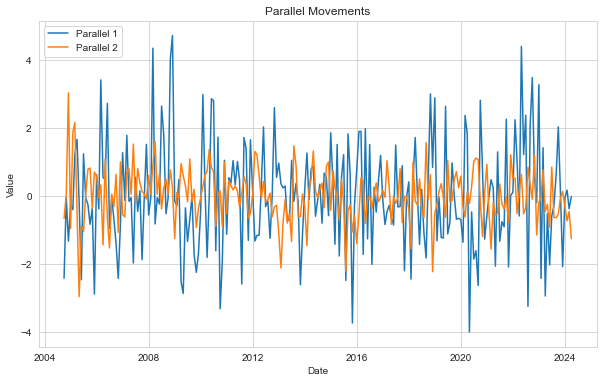

In [33]:
# Standardize the data (monthly returns)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_no_outliers)

# Apply PCA
pca = PCA(n_components=2)  # Select the first two principal components
principal_components = pca.fit_transform(scaled_data)

# Construct parallel movements (first two principal components)
parallel_movements = pd.DataFrame(principal_components, index=data_no_outliers.index, columns=['Parallel_1', 'Parallel_2'])

# Visualize parallel movements
plt.figure(figsize=(10, 6))
plt.plot(parallel_movements.index, parallel_movements['Parallel_1'], label='Parallel 1')
plt.plot(parallel_movements.index, parallel_movements['Parallel_2'], label='Parallel 2')
plt.title('Parallel Movements')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [34]:
print('ADF test for last')
adf_results = pd.DataFrame()
for ticker in data_no_outliers.columns:
    adf_result = adf_test(data_no_outliers[ticker])
    adf_results[ticker] = pd.Series(adf_result)

print(adf_results, '\n \n')

ADF test for last
                                  AAPL       AMZN      GOOGL       MSFT
ADF Test Statistic          -14.241364 -15.413521 -16.131064 -16.144382
p-value                            0.0        0.0        0.0        0.0
#Lags Used                           0          0          0          0
Number of Observations Used        234        234        234        234
Critical Value (1%)          -3.458608  -3.458608  -3.458608  -3.458608
Critical Value (5%)          -2.873972  -2.873972  -2.873972  -2.873972
Critical Value (10%)         -2.573396  -2.573396  -2.573396  -2.573396
Stationary                        True       True       True       True 
 



## Ceating model

In [77]:
stock_data = data_no_outliers #monthly_returns

In [18]:
max_lag = 12
results = []
for p in range(1, max_lag + 1):
    model = VARMAX(stock_data, order=(p, 0))
    try:
        result = model.fit(maxiter=1000, method='powell', disp=False)
        results.append((p, result.aic))
    except Exception as e:
        print(f"Error fitting model with lag order {p}: {e}")
        continue

# Find the lag order with the lowest AIC
best_lag, best_aic = min(results, key=lambda x: x[1])

print("Best lag order:", best_lag)
print("Corresponding AIC:", best_aic)


Best lag order: 1
Corresponding AIC: -2105.979228966571


In [70]:
var_results = VARMAX(stock_data, order=(best_lag, 0))
var_results_fitted = var_results.fit(disp=False)
residuals = var_results_fitted.resid
durbin_watson_statistic = durbin_watson(residuals)

is_stable = all(durbin_watson_statistic >= 1.5) and all(durbin_watson_statistic <= 2.5)
print(f'Is the VAR model stable? {is_stable}')


Is the VAR model stable? True


In [43]:
dw_test = durbin_watson(residuals)
for col, val in zip(data_no_outliers.columns, dw_test):
    print(f'{col}: {val:.2f}')


AAPL: 1.98
AMZN: 2.01
GOOGL: 1.95
MSFT: 1.96


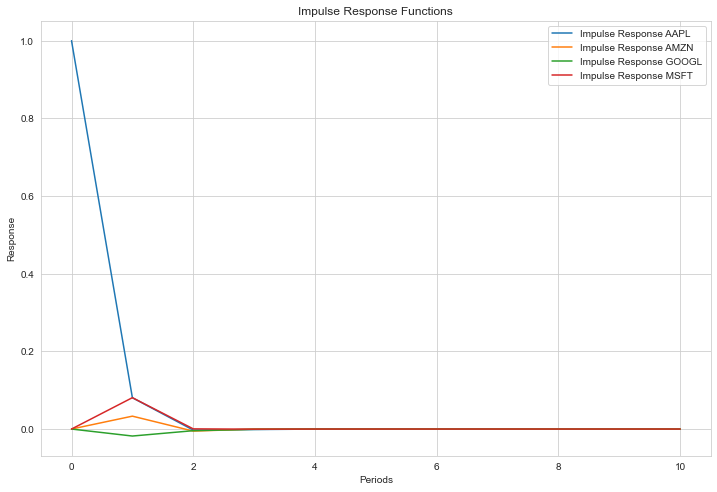

In [76]:
var_results = VARMAX(stock_data, order=(1, 0))
var_results_fitted = var_results.fit(disp=False)

irf = var_results_fitted.impulse_responses(steps=10)

irf_df = pd.DataFrame(irf, columns=stock_data.columns)

plt.figure(figsize=(12, 8))
for column in irf_df.columns:
    plt.plot(irf_df.index, irf_df[column], label=f'Impulse Response {column}')
plt.title('Impulse Response Functions')
plt.xlabel('Periods')
plt.ylabel('Response')
plt.legend()
plt.show()

In [78]:
var_results_fitted = var_results.fit(disp=False)
forecast = var_results_fitted.forecast(steps=12)
forecast_index = pd.date_range(start=stock_data.index[-1], periods=12, freq='B')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=stock_data.columns)

In [79]:
forecast_df

Ticker,AAPL,AMZN,GOOGL,MSFT
2024-04-01,NaN,NaN,NaN,NaN
2024-04-02,NaN,NaN,NaN,NaN
2024-04-03,NaN,NaN,NaN,NaN
2024-04-04,NaN,NaN,NaN,NaN
2024-04-05,NaN,NaN,NaN,NaN
2024-04-08,NaN,NaN,NaN,NaN
2024-04-09,NaN,NaN,NaN,NaN
2024-04-10,NaN,NaN,NaN,NaN
2024-04-11,NaN,NaN,NaN,NaN
2024-04-12,NaN,NaN,NaN,NaN


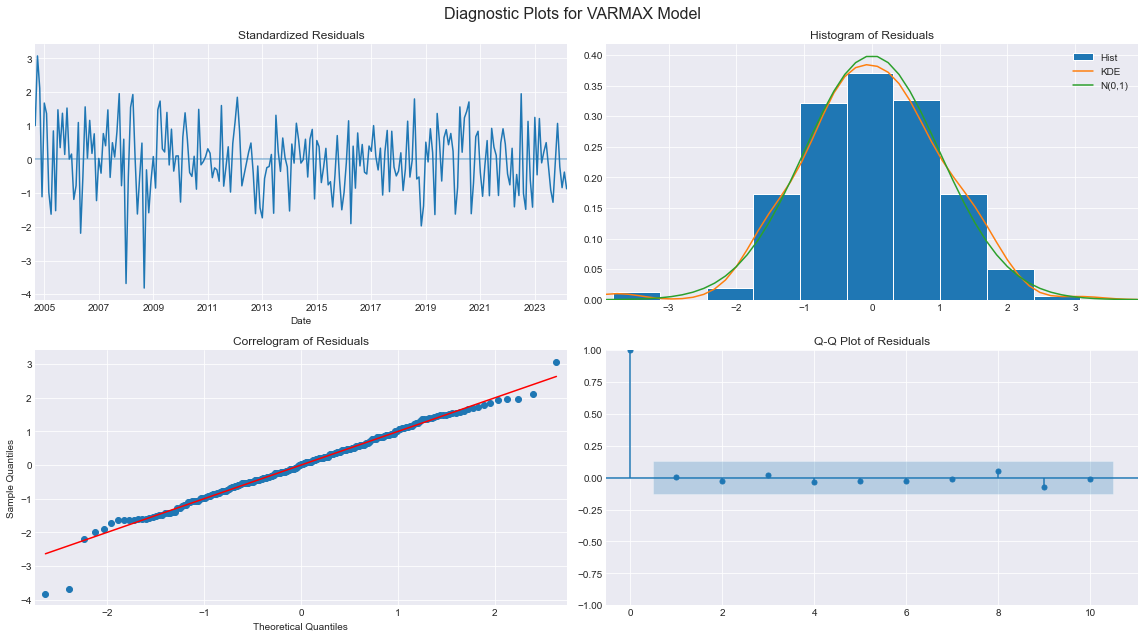

In [85]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(16, 9))

var_results_fitted.plot_diagnostics(fig=fig)

ax = fig.axes
ax[0].set_title('Standardized Residuals')
ax[1].set_title('Histogram of Residuals')
ax[2].set_title('Correlogram of Residuals')
ax[3].set_title('Q-Q Plot of Residuals')

plt.suptitle('Diagnostic Plots for VARMAX Model', fontsize=16)
plt.tight_layout()
plt.show()

In [86]:
try:
    var_results_fitted = var_results.fit(disp=False)
    forecast = var_results_fitted.forecast(steps=12)
except Exception as e:
    print(f"An error occurred: {e}")

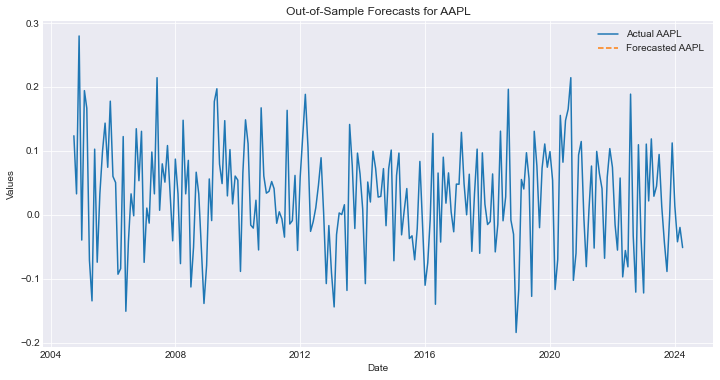

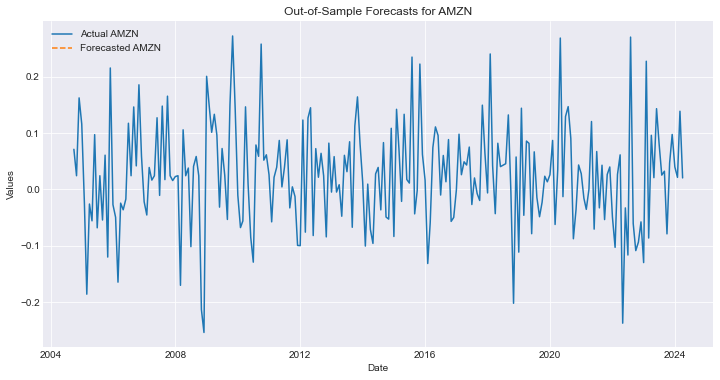

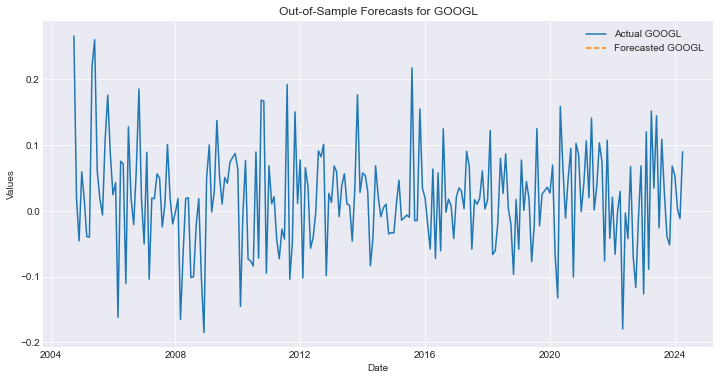

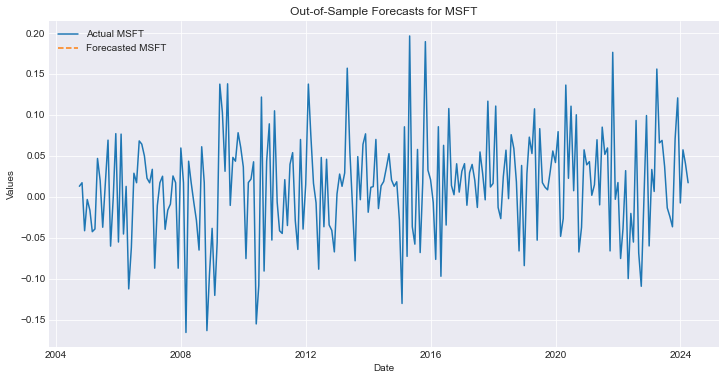

In [87]:
for column in forecast_df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data[column], label=f'Actual {column}')
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecasted {column}', linestyle='dashed')
    plt.legend()
    plt.title(f'Out-of-Sample Forecasts for {column}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.show()

In [88]:
var_results_fitted = var_results.fit(disp=False)
forecast = var_results_fitted.forecast(steps=18)
forecast_index = pd.date_range(start=stock_data.index[-1], periods=18, freq='B')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=stock_data.columns)

In [89]:
forecast_df

Ticker,AAPL,AMZN,GOOGL,MSFT
2024-04-01,NaN,NaN,NaN,NaN
2024-04-02,NaN,NaN,NaN,NaN
2024-04-03,NaN,NaN,NaN,NaN
2024-04-04,NaN,NaN,NaN,NaN
2024-04-05,NaN,NaN,NaN,NaN
2024-04-08,NaN,NaN,NaN,NaN
2024-04-09,NaN,NaN,NaN,NaN
2024-04-10,NaN,NaN,NaN,NaN
2024-04-11,NaN,NaN,NaN,NaN
2024-04-12,NaN,NaN,NaN,NaN


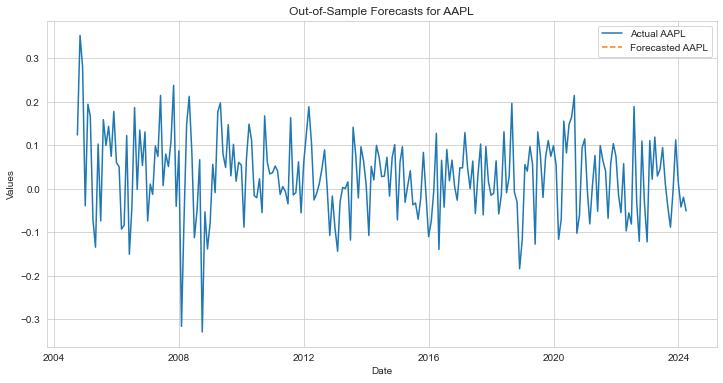

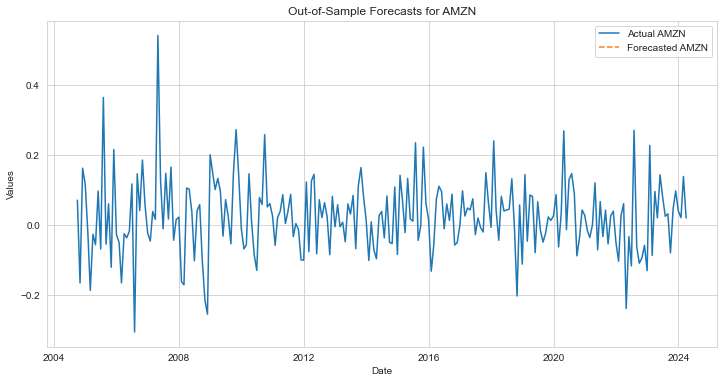

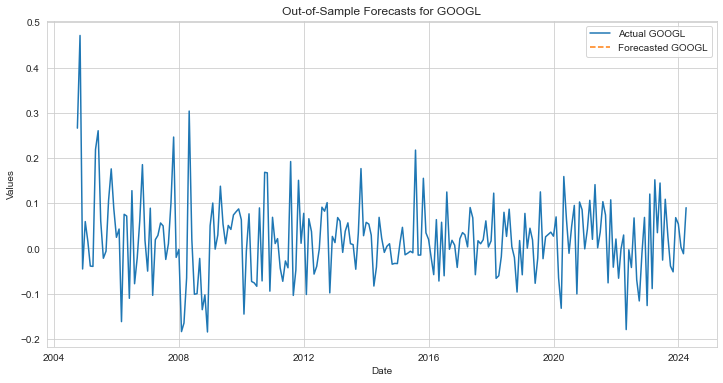

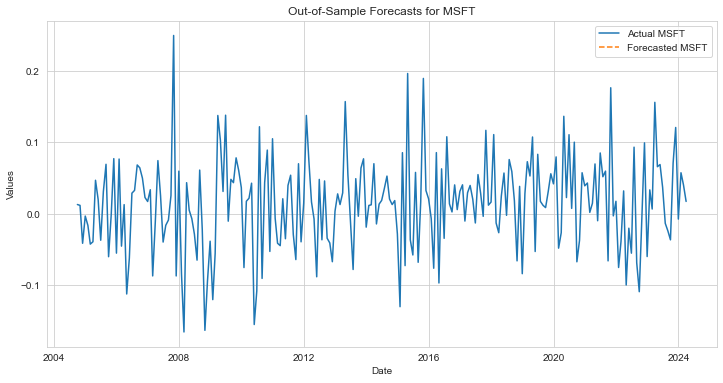

In [50]:
for column in forecast_df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data[column], label=f'Actual {column}')
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecasted {column}', linestyle='dashed')
    plt.legend()
    plt.title(f'Out-of-Sample Forecasts for {column}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.show()

### Thank you!